In [55]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


# LOAD THE DATA

In [56]:


# Load Data
graph = pd.read_csv('data/graph.csv')

graph

,source,target,weight
0,1084949174,1050463558,1
1,1084949174,1002148361,1
2,1084949174,1000741574,1
3,1084949174,1019020642,1
4,1084949174,1044910984,1
...,...,...,...
94879,1051021947,1003736990,1
94880,1049442903,1010058843,1
94881,1094656395,1024023012,1
94882,1040286105,1071783991,1


In [57]:
dataset = pd.read_json('data/dataset.json')

dataset

,timestamp,text,text_id,user,user_id
0,2024-10-31 00:00:00,Running a business means juggling countless ad...,2018569761,danielwoodard,1077866112
1,2024-10-31 00:00:00,Liz Truss is walking in the lingering shadow o...,2092717718,nelsonjacqueline,1089670430
2,2024-10-31 00:00:00,The UK is bracing for war as government buildi...,2059143248,ihooper,1007478642
3,2024-10-31 00:00:00,Marrying a second or third cousin once removed...,2008209828,wrightnicholas,1039258480
4,2024-10-31 00:00:00,It's truly disgraceful how the Indian National...,2001239278,michael51,1021455936
...,...,...,...,...,...
70255,2024-10-31 23:59:52,"@bakerjulie: ""Saranghae, I’m your resident K-P...",2086649509,valdezjennifer,1094330726
70256,2024-10-31 23:59:52,Soaring to new heights with @sweeneyanthony! T...,2039889186,nashshaun,1015245531
70257,2024-10-31 23:59:54,"Hey @james20 @paul47, did you see the latest f...",2020468196,brownregina,1029384492
70258,2024-10-31 23:59:58,Check out the fundraiser exhibition by @joanna...,2037744299,dkey,1046050046


# PCA

Scenarios Where PCA Is Commonly Used
Text Clustering: Dimensionality reduction of TF-IDF matrices using PCA before applying clustering algorithms like k-means.
Text Visualization: Reducing high-dimensional text representations to 2D/3D for plotting.
Preprocessing in NLP Pipelines: Compressing large text feature spaces into more manageable sizes.

## Step 1: Preprocessing the data



PCA requires a numerical data representation to be able to calculate Eigenvectors etc. during its process:

### Step 1.1: Preprocess dataset.json



Possible Approach:

*Dataset 1: dataset.json*
Features:
- timestamp: Can be converted to a numerical format (e.g., Unix timestamp or days from a reference date).
- text: Cannot directly be used; instead, we can use text embedding techniques like *TF-IDF* or sentence embeddings to represent this as numerical data.
- text_id, user, user_id: Unique identifiers; user_id and text_id may be relevant for joining or relational purposes but not for PCA directly.

In [58]:
# Clone the dataset for PCA
dataset_pca = dataset.copy()

##### Step 1.1.1 Convert Timestamp to integer-format

In [59]:
# Convert timestamp to numerical format

# get the earliest timestamp
earliest_timestamp = dataset_pca['timestamp'].min()

# use the earliest timestamp as the base, and convert the timestamp to seconds
dataset_pca['timestamp'] = (dataset_pca['timestamp'] - earliest_timestamp).dt.total_seconds()

dataset_pca['timestamp']

0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
          ...   
70255    86392.0
70256    86392.0
70257    86394.0
70258    86398.0
70259    86399.0
Name: timestamp, Length: 70260, dtype: float64

#### Step 1.1.2: Preprocessing of `text`.

**Cleaning the `text` field of irrelevant data**
   - Remove stopwords from the `text`-field, store the result in a new column **text_preprocessed** 


**Transforming Text Data into Numerical Features**
   - The `text` field in the dataset is converted into numerical features using the **TF-IDF (Term Frequency-Inverse Document Frequency)** method.
   - **Reasoning**: TF-IDF captures the importance of words in each document relative to the entire corpus, emphasizing unique and meaningful terms while down-weighting commonly occurring ones (e.g., stopwords).


**Handling Sparsity with TruncatedSVD**
   - Since TF-IDF produces a sparse matrix, **TruncatedSVD** is used to reduce dimensionality while retaining as much variance as possible.
   - **Why SVD instead of PCA**: TruncatedSVD handles sparse matrices efficiently without requiring dense conversion.

##### Step 1.1.2.1 Cleaning of 'Text' field

In [69]:

tfidf_vectorizer_raw = TfidfVectorizer(max_features=500)
text_features_raw = tfidf_vectorizer_raw.fit_transform(dataset_pca['text'])
feature_names_raw = tfidf_vectorizer_raw.get_feature_names_out()

# Compute average scores again
tfidf_matrix_raw = text_features_raw.toarray()
average_tfidf_scores_raw = np.mean(tfidf_matrix_raw, axis=0)
sorted_features_raw = sorted(zip(feature_names_raw, average_tfidf_scores_raw), key=lambda x: x[1], reverse=True)

print("Top 50 TF-IDF Features After Preprocessing:")
for term, score in sorted_features_raw[:50]:
    print(f"{term}: {score:.4f}")

Top 50 TF-IDF Features After Preprocessing:
the: 0.0983
to: 0.0710
and: 0.0681
for: 0.0637
co: 0.0563
https: 0.0560
of: 0.0507
in: 0.0495
it: 0.0432
is: 0.0429
your: 0.0377
on: 0.0367
with: 0.0358
business: 0.0356
health: 0.0332
you: 0.0281
out: 0.0273
this: 0.0271
our: 0.0268
at: 0.0251
can: 0.0250
let: 0.0238
yhawkins: 0.0228
are: 0.0214
we: 0.0214
check: 0.0203
from: 0.0198
politics: 0.0193
just: 0.0192
that: 0.0190
all: 0.0186
time: 0.0178
about: 0.0176
as: 0.0176
more: 0.0176
my: 0.0174
be: 0.0174
vote: 0.0163
not: 0.0156
their: 0.0156
science: 0.0156
by: 0.0154
support: 0.0148
new: 0.0146
don: 0.0146
like: 0.0146
but: 0.0137
make: 0.0136
up: 0.0135
here: 0.0132


The above are the top 50 words ranked by importance. We can see many stopwords like `the`, `to`, `and`, `for`, `of`, `in`, `is`. They are high-frequency, low-information terms and need irrelevant for the analysis.

Words like `co` and `https` suggest that URLs or special tokens are present in the text. We remove these aswell.

In [ ]:
dataset_pca['text_preprocessed'] = dataset_pca['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True) # Remove URLs
dataset_pca['text_preprocessed'] = dataset_pca['text_preprocessed'].str.replace(r'\bhttps\b', '', regex=True) # Remove standalone 'https'
dataset_pca['text_preprocessed'] = dataset_pca['text_preprocessed'].str.replace(r'\b\d+\b', '', regex=True)  # Remove standalone numbers
# TODO: Remove more words...


tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Compute average scores again
tfidf_matrix = text_features.toarray()
average_tfidf_scores = np.mean(tfidf_matrix, axis=0)
sorted_features = sorted(zip(feature_names, average_tfidf_scores), key=lambda x: x[1], reverse=True)

print("Top 50 TF-IDF Features After Preprocessing:")
for term, score in sorted_features[:50]:
    print(f"{term}: {score:.4f}")

Top 50 TF-IDF Features After Preprocessing:
business: 0.0443
health: 0.0410
let: 0.0291
yhawkins: 0.0268
just: 0.0259
politics: 0.0256
check: 0.0252
time: 0.0227
vote: 0.0195
science: 0.0194
like: 0.0194
don: 0.0182
support: 0.0180
new: 0.0177
make: 0.0161
climate: 0.0159
love: 0.0143
social: 0.0139
hey: 0.0138
need: 0.0135
world: 0.0128
artist: 0.0122
voting: 0.0120
btsbbmas: 0.0119
people: 0.0118
mental: 0.0116
healthcare: 0.0114
join: 0.0114
latest: 0.0112
best: 0.0110
ready: 0.0106
high: 0.0101
rt: 0.0099
bbmas: 0.0098
change: 0.0097
crucial: 0.0097
army: 0.0097
stay: 0.0095
real: 0.0094
help: 0.0092
wait: 0.0092
looking: 0.0092
low: 0.0092
energy: 0.0091
impact: 0.0090
miss: 0.0090
bts: 0.0089
work: 0.0089
care: 0.0086
important: 0.0083


The irrelevant words are removed.

##### Step 1.1.2.2 Pick a value for max_features

**Limiting the Vocabulary (`max_features=500`)**
   - To manage the high dimensionality of textual data, only the **top 500 most relevant terms** are retained.
   - **Justification**: 
     - This decision balances computational efficiency with information retention.
     - The cumulative explained variance plot for different `max_features` values showed that 500 features provide a good trade-off.


If max_features=500, only the 500 most frequent and impactful terms will be retained, while the rest are discarded.

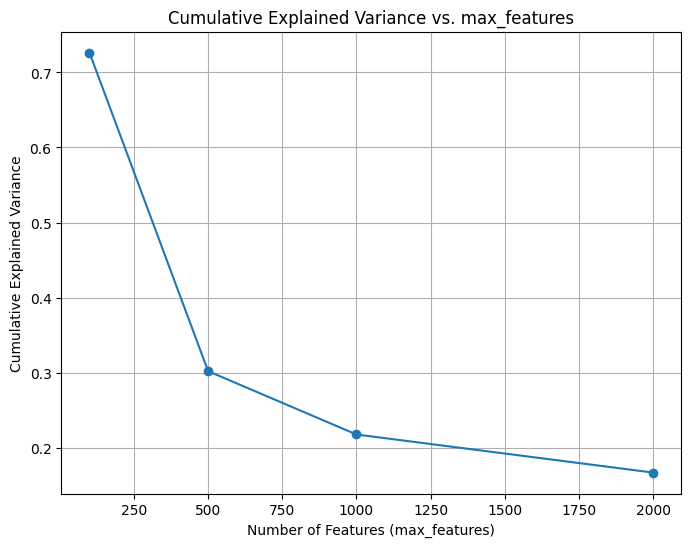

In [67]:


# Test different values for max_features
feature_sizes = [100, 500, 1000, 2000]
explained_variances = []

for max_features in feature_sizes:
    
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])
    
    # Apply SVD
    svd = TruncatedSVD(n_components=50, random_state=42)
    svd.fit(text_features)
    explained_variances.append(svd.explained_variance_ratio_.sum())

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(feature_sizes, explained_variances, marker='o')
plt.title('Cumulative Explained Variance vs. max_features')
plt.xlabel('Number of Features (max_features)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


When max_features is small (e.g., 250 or 500), the TF-IDF vectorizer focuses only on the most frequent and impactful terms, which tend to capture a large portion of the variability in the text data. This is why higher max_feature values lead to smaller cumulative explained variance: The added features dilute the relative contribution of the most impactful features, so the variance captured by the top components in SVD appears smaller.


**max_features=500 is a good choice because it captures a large portion of the variance** -> Only the 500 most frequent and impactful terms will be retained, while the rest are discarded.

##### Step 1.1.2.3 Pick a value for n_components




To optimize the number of components (`n_components`), the **cumulative explained variance** was analyzed for different values. This helps determine how much information is retained as the dimensionality is reduced.

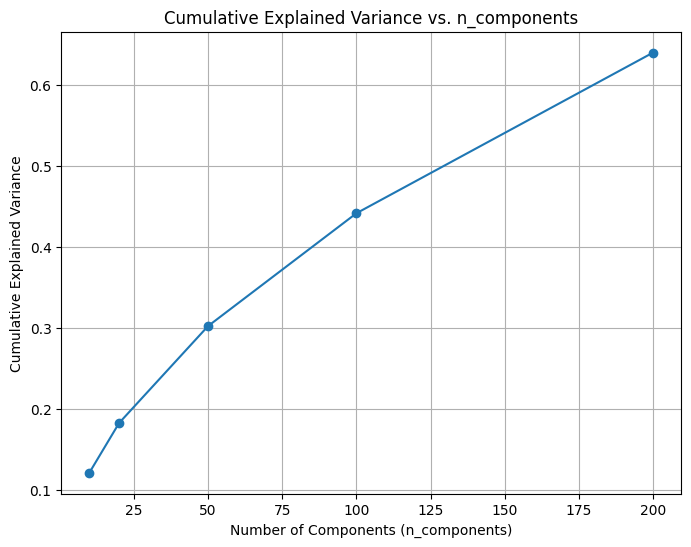

In [68]:
# Test different values for n_components
n_components_list = [10, 20, 50, 100, 200]
cumulative_variances = []

# Use fixed max_features=500 based on previous decision
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])

for n_components in n_components_list:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(text_features)
    cumulative_variances.append(svd.explained_variance_ratio_.sum())

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, cumulative_variances, marker='o')
plt.title('Cumulative Explained Variance vs. n_components')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


There's no clear elbow point in this plot: The variance is distributed across many components without a sharp plateau. This is common in text data represented by TF-IDF.

We can run the downstream analysis using different values of n_components (50, 100, 200) and compare the results.

#### Step 1.1.2.4 Incorporate Features into the dataset



In [ ]:
# Use the last value of n_components from your loop (or any desired value)

final_n_components = 50  # Adjust based on downstream requirements

# Apply TruncatedSVD to get the reduced features
svd = TruncatedSVD(n_components=final_n_components, random_state=42)
svd_features = svd.fit_transform(text_features)

# Create a DataFrame for the reduced features
svd_features_df = pd.DataFrame(
    svd_features, 
    columns=[f"svd_{i}" for i in range(final_n_components)]  # Name components svd_0, svd_1, ...
)

# Combine the reduced features with the original dataset
dataset_pca_combined = pd.concat([dataset_pca.reset_index(drop=True), svd_features_df], axis=1)

# Drop the original text columns if no longer needed
dataset_pca_combined = dataset_pca_combined.drop(['text', 'text_preprocessed'], axis=1)

# Verify the structure of the combined dataset
dataset_pca_combined.head()


,timestamp,text_id,user,user_id,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,0.0,2018569761,danielwoodard,1077866112,0.137296,0.246074,-0.064294,-0.237251,-0.115311,0.012913,...,-0.065538,0.021894,0.018283,-0.061222,0.092196,-0.072486,-0.064620,0.015680,-0.035311,0.000077
1,0.0,2092717718,nelsonjacqueline,1089670430,0.052045,0.078701,-0.013910,0.011797,0.381784,-0.109065,...,-0.041789,0.026066,-0.046934,-0.005784,0.076300,-0.069258,0.057674,0.018460,-0.035936,-0.034303
2,0.0,2059143248,ihooper,1007478642,0.047851,0.065737,-0.009422,0.017950,0.040634,-0.000532,...,0.055979,0.070361,-0.026706,-0.053476,0.044931,0.048196,-0.034467,-0.050436,0.039347,0.008440
3,0.0,2008209828,wrightnicholas,1039258480,0.049751,0.069630,-0.010421,-0.004585,0.038319,0.294748,...,0.014684,0.043072,-0.001647,-0.017984,0.000109,0.042156,-0.024534,0.024413,-0.012211,-0.027591
4,0.0,2001239278,michael51,1021455936,0.125521,0.057410,-0.014362,0.017256,0.312028,-0.067264,...,-0.005985,-0.003214,-0.019909,-0.017777,-0.036939,-0.024025,0.002934,0.007823,0.006778,-0.002722


### Step 1.1.3 Normalization

Ensure all features in the dataset have the same scale. 

TODO: Is this necessary? 

In [72]:

# Normalize all numerical features
scaler = StandardScaler()

# Normalize all columns except text_id and user_id
normalized_data = scaler.fit_transform(dataset_pca_combined[['timestap']])

# Create a normalized DataFrame
normalized_dataset = pd.DataFrame(normalized_data, columns=dataset_pca_combined.select_dtypes(include=['float64', 'int64']).columns)

normalized_dataset

,timestamp,text_id,user_id,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,-1.494226,-1.092095,0.982531,0.116784,1.420350,-0.528097,-1.973111,-1.129412,0.020624,-1.297505,...,-1.181623,0.351902,0.336169,-1.057408,1.601540,-1.287690,-1.160052,0.249718,-0.646736,0.005185
1,-1.494226,1.478923,1.390223,-0.664159,0.101094,-0.155403,0.062445,3.320698,-1.221863,-1.366763,...,-0.778874,0.423135,-0.782306,-0.091561,1.323335,-1.230897,1.021619,0.299502,-0.658002,-0.615846
2,-1.494226,0.314757,-1.448476,-0.702583,-0.001090,-0.122210,0.112740,0.266641,-0.116328,0.271588,...,0.879121,1.179412,-0.435400,-0.922464,0.774371,0.835509,-0.622137,-0.934286,0.697634,0.156247
3,-1.494226,-1.451317,-0.350880,-0.685176,0.029597,-0.129596,-0.071450,0.245914,2.891424,-0.759740,...,0.178819,0.713497,-0.005626,-0.304109,-0.010051,0.729250,-0.444937,0.406107,-0.230785,-0.494602
4,-1.494226,-1.693015,-0.965736,0.008917,-0.066727,-0.158747,0.107067,2.696229,-0.796071,-0.893629,...,-0.171689,-0.076769,-0.318829,-0.300509,-0.658424,-0.435107,0.045081,0.109017,0.111156,-0.045381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70255,1.993873,1.268513,1.551178,-0.224072,0.151636,-0.230304,-0.382750,-0.411595,0.902190,-1.466256,...,-1.668738,1.158076,-0.088422,0.236322,-0.636093,0.686168,0.199416,-0.228442,-0.107248,-0.012199
70256,1.993873,-0.352862,-1.180227,-0.573384,0.133203,-0.163104,-0.073650,0.192141,0.409397,0.065579,...,-0.015290,-0.634568,0.787654,0.387083,-0.678384,0.081931,-2.282277,2.132100,1.403531,-2.623418
70257,1.993954,-1.026268,-0.691903,0.497733,0.473864,-0.256539,-0.097737,0.936179,1.274476,2.692510,...,-1.938720,2.467355,1.934511,1.781355,-1.353630,0.922656,1.923843,0.120028,-1.381921,-0.760979
70258,1.994115,-0.427234,-0.116316,0.571543,1.117988,-0.439914,1.978781,-1.303947,-0.301855,-1.159352,...,0.443285,1.326635,1.255608,-0.013074,0.640304,0.121734,-0.530871,-0.243951,-2.064086,-0.236365


In [66]:
# Clone the graph for PCA
graph_pca = graph.copy()

# Compute numerical features for graph


### Preprocess graph.csv

*Dataset 2: graph.csv*
This dataset represents a graph. To use this for PCA, we can compute numerical features from the graph, such as:
- Degree centrality.
- Betweenness centrality.
- Clustering coefficient.